# Refine labels for NK cells

In this notebook, we load all CD56dim and CD56bright NK cells across our subjects to refine final L3 labels. We'll combine, recluster, and assign final labels by taking the most frequent AIFI_L3 label in each cluster, and back-propogate those L3 labels to L2 and L1 based on our cell type hierarcy.

We'll also generate metadata, UMAP coordinates, and marker gene summaries for review of our final labels, then store all of the outputs in HISE for later use.

Because there are many NK cells, we'll divide them into smaller subsets based on cohort, sex, and visit grouping (defined below). Unlike some other cell types, we'll combine CMV-positive and CMV-negative samples to enhance our ability to detect CMV-responsive populations. We'll then review each subset and assemble all labeled data in later notebooks.

**Note:** While Harmony integration by subjects works quite well for many cell classes to avoid subject-specific separation of clusters, I've found that for NK cells this leads to loss of clear separation of Adaptive NK cells - possibly because these are biased towards CMV-positive individuals. As a result, we run Harmony for batch rather than subject in this process.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from datetime import date
import hisepy
import os
import pandas as pd
import re
import scanpy as sc
import scanpy.external as sce
import tarfile

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
rev_dir = 'output/review'
if not os.path.isdir(rev_dir):
    os.makedirs(rev_dir)

In [4]:
class_name = 'nk_cell'

## Helper functions

### HISE data
These functions make it easy to utilize files from the HISE cache

In [5]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [6]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def read_obs_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    obs = res.obs.copy()
    return obs

### Label refinement

This function uses the most frequent label within each cluster to refine label assignments.

In [9]:
def single_value(series):
    res = []
    for value in series:
        if isinstance(value, list):
            res.append(value[0])
        else:
            res.append(value)
    return res

In [10]:
def assign_most_frequent(adata, clusters, labels, keep_original = False, original_prefix = 'predicted_'):
    obs = adata.obs
    
    most_frequent_labels = (
        adata.obs
        .groupby(clusters)[labels]
        .agg(pd.Series.mode)
        .to_frame()
        .reset_index()
    )
    most_frequent_labels[labels] = single_value(most_frequent_labels[labels])
    
    if keep_original:
        obs = obs.rename({labels: original_prefix + labels}, axis = 1)
    else:
        obs = obs.drop(labels, axis = 1)
    
    obs = obs.merge(most_frequent_labels, on = clusters, how = 'left')
    
    adata.obs = obs
    
    return adata

This function back-propagates hierarchical labeling from AIFI_L3 back to AIFI_L2 and AIFI_L1 to ensure our labels agree across levels of our cell type hierarchy.

In [11]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
    
    adata.obs = obs

    return adata

### Review outputs

These functions are used to assemble marker gene expression tables for review

In [12]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def marker_mean_df(adata, markers, log = False, clusters = 'louvain_2'):
    gene_cl_mean = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True,
        log = log
    ).dot_color_df
    
    return gene_cl_mean

def tidy_marker_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, markers, clusters)
    gene_cl_frac = gene_cl_frac.reset_index(drop = False)
    gene_cl_frac = pd.melt(gene_cl_frac, id_vars = clusters, var_name = 'gene', value_name = 'gene_frac')
    
    gene_cl_mean = marker_mean_df(adata, markers, log = False, clusters = clusters)
    gene_cl_mean = gene_cl_mean.reset_index(drop = False)
    gene_cl_mean = pd.melt(gene_cl_mean, id_vars = clusters, var_name = 'gene', value_name = 'gene_mean')

    marker_df = gene_cl_frac.merge(gene_cl_mean, on = [clusters, 'gene'], how = 'left')
    return marker_df

This function will select clusters based on gene detection above a specifiec fraction of cells (cutoff).

In [13]:
def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

This function retrieves both observations and UMAP coordinates in a single table for review.

In [14]:
def obs_with_umap(adata):
    obs = adata.obs
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']

    return obs

This function applies data analysis methods to our scRNA-seq data, including normalization, HVG selection, PCA, nearest neighbors, UMAP, and Leiden clustering.

In [15]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')

    print('Harmony', end = "; ")
    # Integrate batches
    sce.pp.harmony_integrate(
        adata, 
        'batch_id',
        max_iter_harmony = 30,
        verbose = False
    )
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 30,
        n_pcs = 30,
        use_rep = 'X_pca_harmony'
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 5
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

These functions are used to iteratively cluster to refine specific cell types. They look for clusters marked by one or more marker genes, then perform a round of re-clustering for the selected clusters to better define these types.

In [16]:
def subset_refinement(adata, cluster_col, clusters, refine_res = 2):
    ref_adata = adata[adata.obs[cluster_col].isin(clusters)]
    ref_adata = process_adata(ref_adata, resolution = refine_res)
    ref_adata = assign_most_frequent(
        ref_adata, 
        'leiden_{r}'.format(r = refine_res), 'AIFI_L3',
        keep_original = True,
        original_prefix = 'predicted_'
    )
    
    ref_df = ref_adata.obs[['barcodes', 'AIFI_L3', 'predicted_AIFI_L3']]

    return ref_df

In [17]:
def isg_hi_refinement(adata, cluster_col = 'leiden_2', refine_res = 2):
    sel_cl = select_clusters_above_gene_frac(
        adata, 'IFI44L', 0.1, clusters = cluster_col
    )
    print('ISG-high: {c}'.format(c = sel_cl))

    if len(sel_cl) > 0:
        res = subset_refinement(
            adata, 
            cluster_col = cluster_col, 
            clusters = sel_cl, 
            refine_res = refine_res
        )
    else:
        res = pd.DataFrame({'barcodes': [''], 'AIFI_L3': [''], 'predicted_AIFI_L3': ['']})
    return res

In [18]:
def gzmk_refinement(adata, cluster_col = 'leiden_2', refine_res = 2):
    gzmb_pos_cl = select_clusters_above_gene_frac(
        adata, 'GZMB', cutoff = 0.6, clusters = cluster_col
    )
    gzmk_pos_cl = select_clusters_above_gene_frac(
        adata, 'GZMK', cutoff = 0.2, clusters = cluster_col
    )
    sel_cl = set(gzmb_pos_cl) & set(gzmk_pos_cl)
    sel_cl = list(sel_cl)
    print('GZMK-pos GZMB-pos: {c}'.format(c = sel_cl))
    
    if len(sel_cl) > 0:
        res = subset_refinement(
            adata, 
            cluster_col = cluster_col, 
            clusters = sel_cl, 
            refine_res = refine_res
        )
    else:
        res = pd.DataFrame({'barcodes': [''], 'AIFI_L3': [''], 'predicted_AIFI_L3': ['']})
    return res

In [19]:
def adaptive_refinement(adata, cluster_col = 'leiden_2', refine_res = 2):
    gzmk_pos_cl = select_clusters_above_gene_frac(
        adata, 'GZMK', cutoff = 0.4, clusters = cluster_col
    )
    ptms_pos_cl = select_clusters_above_gene_frac(
        adata, 'PTMS', 0.05, clusters = cluster_col
    )
    sel_cl = set(ptms_pos_cl) - set(gzmk_pos_cl)
    sel_cl = list(sel_cl)
    print('Adaptive: {c}'.format(c = sel_cl))

    if len(sel_cl) > 0:
        res = subset_refinement(
            adata, 
            cluster_col = cluster_col, 
            clusters = sel_cl, 
            refine_res = refine_res
        )
    else:
        res = pd.DataFrame({'barcodes': [''], 'AIFI_L3': [''], 'predicted_AIFI_L3': ['']})
    return res

In [20]:
def label_substitution(adata, labels):
    sub_idx = adata.obs['barcodes'].isin(labels['barcodes'])
    sub_adata = adata[sub_idx]
    
    adata = adata[[not x for x in sub_idx]]
    
    sub_obs = sub_adata.obs.drop(['AIFI_L3', 'predicted_AIFI_L3'], axis = 1)
    sub_obs = sub_obs.reset_index(drop = True)
    sub_obs = sub_obs.merge(labels, on = 'barcodes', how = 'left')
    sub_obs = sub_obs.set_index('barcodes', drop = False)
    sub_adata.obs = sub_obs
    
    adata = sc.concat([adata, sub_adata])
    return adata

## Cell Type Markers

These are the set of marker genes that we'll use to review our cell type labels.

In [21]:
l2_markers = [
    'FCGR3A', 'MKI67', 'NCAM1'
]

l3_markers = [
    'FCER1G', 'FCGR3A', 'GZMK', 'KLRC2',
    'MKI67', 'MX1', 'NCAM1', 'ZBTB16',
    'PTMS'
]

## Read cell type hierarchy from HISE

As part of label refinement, we'll back-propagate our cell type labels from refined AIFI_L3 labels to their parent cell classes at AIFI_L2 and AIFI_L1. To do this, we need the hierarchical relationships between these levels, which have been generated for our cell type reference dataset.

In [22]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Read sample metadata from HISE

We previously assembled sample metadata and CMV status for each subject. We'll retrieve and combine these to utilize for selecting subsets of samples.

In [23]:
sample_meta_uuid = 'd82c5c42-ae5f-4e67-956e-cd3b7bf88105'
sample_meta = read_csv_uuid(sample_meta_uuid)

In [24]:
sample_meta.shape

(868, 32)

In [25]:
cmv_meta_uuid = '9469f67c-b09a-454d-9fb9-f50ff3494d69'
cmv_path = cache_uuid_path(cmv_meta_uuid)
cmv_meta = pd.read_csv(cmv_path, index_col = 0)
cmv_meta = cmv_meta.drop_duplicates()

In [26]:
cmv_meta.shape

(96, 4)

In [27]:
sample_meta = sample_meta.merge(cmv_meta, on = 'subject.subjectGuid', how = 'left')

In [28]:
sample_meta.shape

(868, 35)

## Identify files in HISE

For this analysis, we'll read in these files from HISE storage from previous steps.

In [29]:
h5ad_uuids = {
    'BR1_Female_Negative_CD56dim-NK-cell': 'd35f90dd-1ce4-4743-b07f-d13caa6b271e',
    'BR1_Female_Positive_CD56dim-NK-cell': '994c0e01-c7a5-4533-bc55-dab04f880ae7',
    'BR1_Male_Negative_CD56dim-NK-cell': '40516b72-5052-49b1-97df-8821d52d7893',
    'BR1_Male_Positive_CD56dim-NK-cell': '08411747-d5a1-4d81-8b82-6e64f18f497b',
    'BR2_Female_Negative_CD56dim-NK-cell': 'cbd07e76-7365-402f-bf5a-dae364bf6084',
    'BR2_Female_Positive_CD56dim-NK-cell': 'd0ffe8cf-cdc4-4890-a9d1-665437a9bc25',
    'BR2_Male_Negative_CD56dim-NK-cell': '1b839052-9906-41f6-b50a-41cbac1b2948',
    'BR2_Male_Positive_CD56dim-NK-cell': 'aa29462f-f39b-43b7-93fc-df475ccf94d6',
    'CD56bright-NK-cell': '313e5417-1996-4592-86e7-9d3f5604fdc7'
}

## Read and process data

In [30]:
out_file = 'output/diha_{c}_AIFI_L3_review_{d}.h5ad'.format(c = class_name, d = date.today())
out_review = []

adata_list = []
for group_name, uuid in h5ad_uuids.items():
    group_adata = read_adata_uuid(uuid)
    print('{g}: {n} cells'.format(g = group_name, n = group_adata.shape[0]))
    adata_list.append(group_adata)
    
adata = sc.concat(adata_list)
print('Total: {n} cells'.format(n = adata.shape[0]))
del adata_list

BR1_Female_Negative_CD56dim-NK-cell: 181154 cells
BR1_Female_Positive_CD56dim-NK-cell: 76987 cells
BR1_Male_Negative_CD56dim-NK-cell: 152746 cells
BR1_Male_Positive_CD56dim-NK-cell: 122831 cells
BR2_Female_Negative_CD56dim-NK-cell: 118648 cells
BR2_Female_Positive_CD56dim-NK-cell: 149915 cells
BR2_Male_Negative_CD56dim-NK-cell: 167283 cells
BR2_Male_Positive_CD56dim-NK-cell: 67829 cells
CD56bright-NK-cell: 88824 cells
Total: 1126217 cells


In [31]:
adata = process_adata(adata, resolution = 2)

Normalizing; Finding HVGs; Scaling; PCA; Harmony; 

2024-04-06 16:27:19,394 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-06 16:34:34,935 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


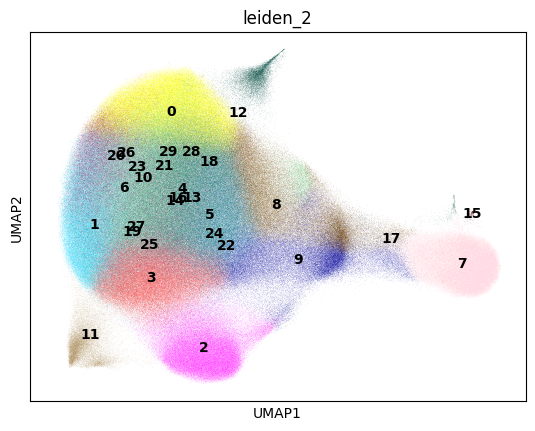

In [32]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


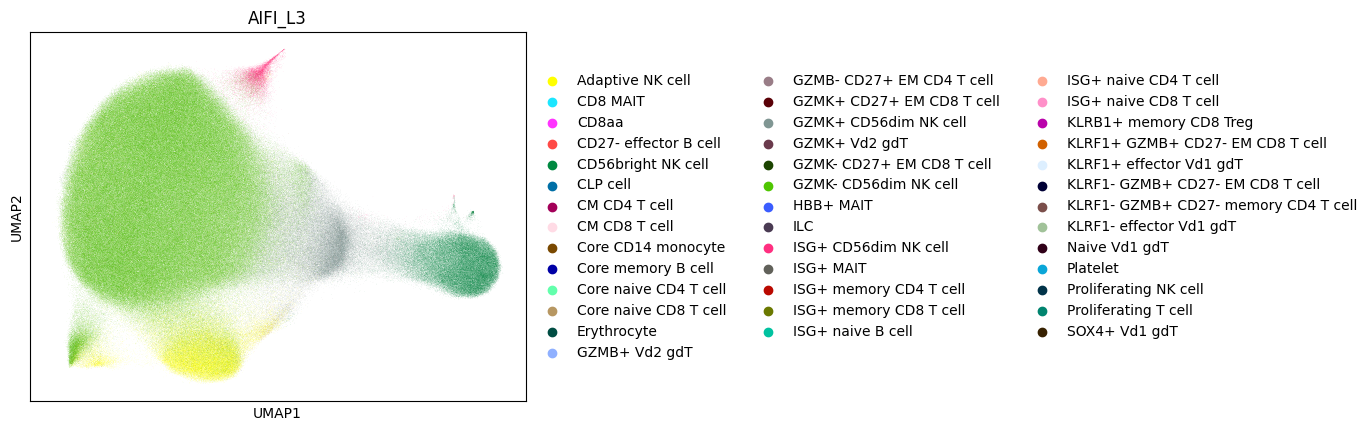

In [33]:
sc.pl.umap(adata, color = 'AIFI_L3')

In [47]:
gzmk_labels = gzmk_refinement(
    adata,
    cluster_col = 'leiden_2',
    refine_res = 3
)

GZMK-pos GZMB-pos: ['8', '9']
Normalizing; Finding HVGs; Scaling; PCA; Harmony; 

2024-04-07 01:28:36,069 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-07 01:30:22,053 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


In [48]:
gzmk_labels['AIFI_L3'].value_counts()

AIFI_L3
GZMK+ CD56dim NK cell    93267
GZMK- CD56dim NK cell    71477
Name: count, dtype: int64

In [53]:
adata = assign_most_frequent(
    adata, 
    'leiden_2', 'AIFI_L3', 
    keep_original = True, 
    original_prefix = 'predicted_'
)

In [59]:
adata = label_substitution(adata, gzmk_labels)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


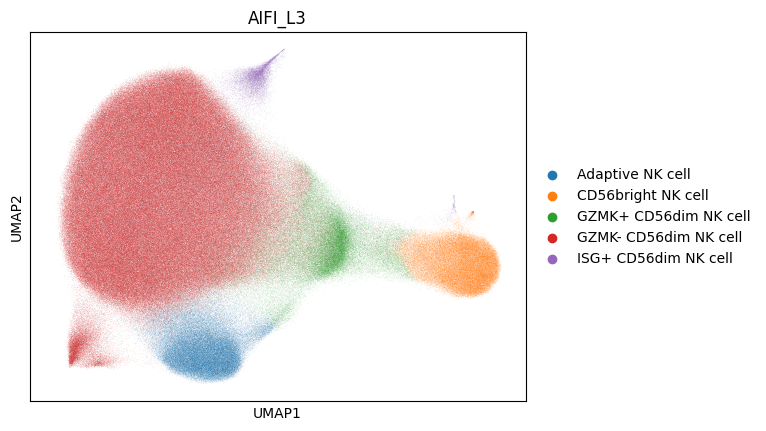

In [60]:
sc.pl.umap(adata, color = 'AIFI_L3')

In [61]:
adata = propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
)

In [62]:
# Save results for this cell type
adata.write_h5ad(out_file)

## Assemble output files for upload

In [63]:
# Save metadata and UMAP
meta_csv = 'output/review/diha_{c}_AIFI_L3_review_meta_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
visit_group_obs = obs_with_umap(adata)
visit_group_obs.to_csv(meta_csv)
out_review.append(meta_csv)

# Save marker expression summaries
out_l2_markers = 'output/review/diha_{c}_AIFI_L2_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l2_marker_df = tidy_marker_df(
    adata,
    l2_markers,
    'AIFI_L2'
)
l2_marker_df.to_csv(out_l2_markers)
out_review.append(out_l2_markers)

out_l3_markers = 'output/review/diha_{c}_AIFI_L3_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l3_marker_df = tidy_marker_df(
    adata,
    l3_markers,
    'AIFI_L3'
)
l3_marker_df.to_csv(out_l3_markers)
out_review.append(out_l3_markers)

### h5ad files

In [64]:
h5ad_files = [out_file]

### Review files

In [65]:
rev_files = os.listdir('output/review')
review_files = []
for rev_file in rev_files:
    if class_name in rev_file:
        review_files.append('{d}/{f}'.format(d = 'output/review', f = rev_file))

### Combine metadata files to assemble a full set

In [66]:
meta_files = []
for review_file in review_files:
    if 'meta' in review_file:
        meta_files.append(review_file)

meta_list = []
for meta_file in meta_files:
    meta_list.append(pd.read_csv(meta_file, index_col = 0))
all_meta = pd.concat(meta_list)

In [67]:
meta_csv = 'output/diha_{c}_AIFI_L3_refinement_meta_{d}.csv'.format(c = class_name, d = date.today())
all_meta.to_csv(meta_csv)
meta_parquet = 'output/diha_{c}_AIFI_L3_refinement_meta_{d}.parquet'.format(c = class_name, d = date.today())
all_meta.to_parquet(meta_parquet)

### Bundle review files into a .tar for later use

In [68]:
review_tar = 'output/diha_{c}_AIFI_L3_refinement_review_{d}.tar.gz'.format(c = class_name, d = date.today())
tar = tarfile.open(review_tar, 'w:gz')
for review_file in review_files:
    tar.add(review_file)
tar.close()

## Upload assembled results to HISE

In [69]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA NK Refinement All AIFI_L3 {d}'.format(d = date.today())

In [72]:
in_files = []
for group_name, uuid in h5ad_uuids.items():
    in_files.append(uuid)
in_files

['d35f90dd-1ce4-4743-b07f-d13caa6b271e',
 '994c0e01-c7a5-4533-bc55-dab04f880ae7',
 '40516b72-5052-49b1-97df-8821d52d7893',
 '08411747-d5a1-4d81-8b82-6e64f18f497b',
 'cbd07e76-7365-402f-bf5a-dae364bf6084',
 'd0ffe8cf-cdc4-4890-a9d1-665437a9bc25',
 '1b839052-9906-41f6-b50a-41cbac1b2948',
 'aa29462f-f39b-43b7-93fc-df475ccf94d6',
 '313e5417-1996-4592-86e7-9d3f5604fdc7']

In [73]:
out_files = h5ad_files + [meta_csv, meta_parquet, review_tar]

In [74]:
out_files

['output/diha_nk_cell_AIFI_L3_review_2024-04-06.h5ad',
 'output/diha_nk_cell_AIFI_L3_refinement_meta_2024-04-07.csv',
 'output/diha_nk_cell_AIFI_L3_refinement_meta_2024-04-07.parquet',
 'output/diha_nk_cell_AIFI_L3_refinement_review_2024-04-07.tar.gz']

In [75]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = 'nk_refinement_all'
)

you are trying to upload file_ids... ['output/diha_nk_cell_AIFI_L3_review_2024-04-06.h5ad', 'output/diha_nk_cell_AIFI_L3_refinement_meta_2024-04-07.csv', 'output/diha_nk_cell_AIFI_L3_refinement_meta_2024-04-07.parquet', 'output/diha_nk_cell_AIFI_L3_refinement_review_2024-04-07.tar.gz']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'cde4cf2b-5336-4344-9a93-3d4fa2f5f702',
 'files': ['output/diha_nk_cell_AIFI_L3_review_2024-04-06.h5ad',
  'output/diha_nk_cell_AIFI_L3_refinement_meta_2024-04-07.csv',
  'output/diha_nk_cell_AIFI_L3_refinement_meta_2024-04-07.parquet',
  'output/diha_nk_cell_AIFI_L3_refinement_review_2024-04-07.tar.gz']}

In [76]:
import session_info
session_info.show()